# Convolutional Variational Autoencoder Implementation for Reconstruction of CelebFaces dataset

In this notebook we train a Variational Autoencoder (VAE) on the CelebFaces dataset (https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). The VAE is a type of autoencoder probabilistic. So instead of leatting our neural network learn an arbitrary function, we are learning the parameters of a probability distribution modeling our data.

### Import the dataset from Kaggle

In [1]:
import kaggle

In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset


  0%|          | 0.00/1.33G [00:00<?, ?B/s]
  0%|          | 1.00M/1.33G [00:00<03:55, 6.06MB/s]
  0%|          | 2.00M/1.33G [00:00<04:04, 5.83MB/s]
  0%|          | 3.00M/1.33G [00:00<03:23, 6.98MB/s]
  0%|          | 4.00M/1.33G [00:00<03:18, 7.15MB/s]
  0%|          | 5.00M/1.33G [00:00<03:00, 7.86MB/s]
  0%|          | 6.00M/1.33G [00:00<02:57, 8.03MB/s]
  1%|          | 7.00M/1.33G [00:01<03:29, 6.78MB/s]
  1%|          | 8.00M/1.33G [00:01<03:23, 6.97MB/s]
  1%|          | 9.00M/1.33G [00:01<03:26, 6.87MB/s]
  1%|          | 11.0M/1.33G [00:01<02:54, 8.14MB/s]
  1%|          | 12.0M/1.33G [00:01<02:47, 8.45MB/s]
  1%|1         | 14.0M/1.33G [00:01<02:30, 9.40MB/s]
  1%|1         | 15.0M/1.33G [00:02<02:54, 8.11MB/s]
  1%|1         | 16.0M/1.33G [00:02<02:52, 8.17MB/s]
  1%|1         | 17.0M/1.33G [00:02<02:51, 8.23MB/s]
  1%|1         | 18.0M/1.33G [00:02<02:50, 8.27MB/s]
  1%|1         | 19.0M/1.33G [00:02<02:43, 8.59MB/s]
  1%|1         | 20.0M/1.33G [00:02<02:57, 7.95MB/s]
 

In [3]:
import os
from glob import glob
 
WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

### Setup

In [4]:
import numpy as np

import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [5]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


### Generate batch

Since using the whole dataset would be very computational expensive we are only using a batch of 512 images.

In [6]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 128 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


### Define the architecture of our encoder and decoder networks 

In this VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively.  Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation $x$ and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 


### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation $x$. Model the latent distribution prior $p(z)$ as a unit Gaussian.


### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). 

### Create a sampling layer

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Build the encoder

In [8]:
latent_dim = Z_DIM

encoder_inputs = keras.Input(shape=INPUT_DIM)


x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.40)(x)

x = layers.Dense(2048)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['leaky_re_lu[0][0]']            
                                                                                            

### Build the decoder

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(2048)(latent_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(4*4*256)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((4,4,256))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 2048)              264192    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              8392704   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        5900

### Define the VAE as a `Model` with a custom `train_step`

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train the VAE

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1.5e-3))
history = vae.fit(data_flow[0][0], epochs=2500, batch_size=128)

Epoch 1/2500
4/4 [==============================] - 22s 115ms/step - loss: 2828.8415 - reconstruction_loss: 2816.7534 - kl_loss: 0.0305
Epoch 2/2500
4/4 [==============================] - 0s 115ms/step - loss: 2977.2987 - reconstruction_loss: 2891.5288 - kl_loss: 0.0610
Epoch 3/2500
4/4 [==============================] - 0s 110ms/step - loss: 2821.0363 - reconstruction_loss: 2820.9092 - kl_loss: 0.3686
Epoch 4/2500
4/4 [==============================] - 0s 115ms/step - loss: 2815.5328 - reconstruction_loss: 2808.9653 - kl_loss: 1.9398
Epoch 5/2500
4/4 [==============================] - 0s 109ms/step - loss: 2783.8158 - reconstruction_loss: 2771.5010 - kl_loss: 2.9985
Epoch 6/2500
4/4 [==============================] - 0s 114ms/step - loss: 2991.1509 - reconstruction_loss: 2976.9075 - kl_loss: 5.0883
Epoch 7/2500
4/4 [==============================] - 0s 114ms/step - loss: 2804.8494 - reconstruction_loss: 2802.9673 - kl_loss: 6.1088
Epoch 8/2500
4/4 [==============================] - 0s

Epoch 61/2500
4/4 [==============================] - 0s 114ms/step - loss: 2261.6363 - reconstruction_loss: 2236.7812 - kl_loss: 29.7975
Epoch 62/2500
4/4 [==============================] - 0s 110ms/step - loss: 2270.0200 - reconstruction_loss: 2234.5430 - kl_loss: 29.4988
Epoch 63/2500
4/4 [==============================] - 0s 112ms/step - loss: 2251.1788 - reconstruction_loss: 2230.2795 - kl_loss: 28.6804
Epoch 64/2500
4/4 [==============================] - 0s 112ms/step - loss: 2261.5050 - reconstruction_loss: 2225.6748 - kl_loss: 30.3899
Epoch 65/2500
4/4 [==============================] - 0s 117ms/step - loss: 2260.2794 - reconstruction_loss: 2223.0894 - kl_loss: 29.5235
Epoch 66/2500
4/4 [==============================] - 0s 114ms/step - loss: 2257.1099 - reconstruction_loss: 2222.9856 - kl_loss: 30.0040
Epoch 67/2500
4/4 [==============================] - 0s 114ms/step - loss: 2253.5857 - reconstruction_loss: 2218.0137 - kl_loss: 31.2152
Epoch 68/2500
4/4 [======================

4/4 [==============================] - 2s 403ms/step - loss: 2157.2797 - reconstruction_loss: 2120.5710 - kl_loss: 34.2541
Epoch 121/2500
4/4 [==============================] - 1s 287ms/step - loss: 2137.9432 - reconstruction_loss: 2116.7749 - kl_loss: 35.8572
Epoch 122/2500
4/4 [==============================] - 1s 220ms/step - loss: 2148.0423 - reconstruction_loss: 2115.5120 - kl_loss: 35.5907
Epoch 123/2500
4/4 [==============================] - 1s 172ms/step - loss: 2163.8994 - reconstruction_loss: 2115.0083 - kl_loss: 36.9436
Epoch 124/2500
4/4 [==============================] - 1s 266ms/step - loss: 2134.7674 - reconstruction_loss: 2107.0059 - kl_loss: 35.7101
Epoch 125/2500
4/4 [==============================] - 1s 232ms/step - loss: 2135.0350 - reconstruction_loss: 2102.3247 - kl_loss: 36.6468
Epoch 126/2500
4/4 [==============================] - 1s 340ms/step - loss: 2123.0623 - reconstruction_loss: 2101.3813 - kl_loss: 36.0988
Epoch 127/2500
4/4 [=============================

4/4 [==============================] - 1s 293ms/step - loss: 2064.8569 - reconstruction_loss: 2036.8870 - kl_loss: 34.5463
Epoch 180/2500
4/4 [==============================] - 1s 413ms/step - loss: 2064.2250 - reconstruction_loss: 2036.6396 - kl_loss: 34.6962
Epoch 181/2500
4/4 [==============================] - 1s 261ms/step - loss: 2059.9200 - reconstruction_loss: 2036.3947 - kl_loss: 34.9299
Epoch 182/2500
4/4 [==============================] - 1s 337ms/step - loss: 2068.2120 - reconstruction_loss: 2034.9702 - kl_loss: 34.3576
Epoch 183/2500
4/4 [==============================] - 1s 351ms/step - loss: 2068.7648 - reconstruction_loss: 2035.2324 - kl_loss: 34.1647
Epoch 184/2500
4/4 [==============================] - 1s 307ms/step - loss: 2066.7380 - reconstruction_loss: 2034.6775 - kl_loss: 34.5556
Epoch 185/2500
4/4 [==============================] - 1s 361ms/step - loss: 2061.1753 - reconstruction_loss: 2031.9833 - kl_loss: 34.7497
Epoch 186/2500
4/4 [=============================

4/4 [==============================] - 1s 340ms/step - loss: 2043.5574 - reconstruction_loss: 2008.7686 - kl_loss: 33.6727
Epoch 239/2500
4/4 [==============================] - 2s 459ms/step - loss: 2034.2631 - reconstruction_loss: 2007.3158 - kl_loss: 33.6308
Epoch 240/2500
4/4 [==============================] - 1s 298ms/step - loss: 2030.5029 - reconstruction_loss: 2007.7828 - kl_loss: 32.6235
Epoch 241/2500
4/4 [==============================] - 1s 351ms/step - loss: 2037.6367 - reconstruction_loss: 2006.8857 - kl_loss: 33.6603
Epoch 242/2500
4/4 [==============================] - 1s 230ms/step - loss: 2040.9817 - reconstruction_loss: 2007.6577 - kl_loss: 33.0204
Epoch 243/2500
4/4 [==============================] - 1s 429ms/step - loss: 2046.4002 - reconstruction_loss: 2007.6904 - kl_loss: 32.8488
Epoch 244/2500
4/4 [==============================] - 1s 240ms/step - loss: 2039.3670 - reconstruction_loss: 2006.7166 - kl_loss: 33.8817
Epoch 245/2500
4/4 [=============================

4/4 [==============================] - 1s 246ms/step - loss: 2029.7260 - reconstruction_loss: 1995.2778 - kl_loss: 32.3248
Epoch 298/2500
4/4 [==============================] - 1s 246ms/step - loss: 2009.3530 - reconstruction_loss: 1994.5874 - kl_loss: 32.9192
Epoch 299/2500
4/4 [==============================] - 1s 209ms/step - loss: 2013.7967 - reconstruction_loss: 1995.0544 - kl_loss: 32.3701
Epoch 300/2500
4/4 [==============================] - 1s 220ms/step - loss: 2014.2355 - reconstruction_loss: 1994.4823 - kl_loss: 32.0139
Epoch 301/2500
4/4 [==============================] - 1s 209ms/step - loss: 2039.9340 - reconstruction_loss: 1994.0105 - kl_loss: 33.0025
Epoch 302/2500
4/4 [==============================] - 1s 298ms/step - loss: 2034.5007 - reconstruction_loss: 1994.6194 - kl_loss: 32.2859
Epoch 303/2500
4/4 [==============================] - 1s 287ms/step - loss: 2029.3282 - reconstruction_loss: 1993.7302 - kl_loss: 32.5377
Epoch 304/2500
4/4 [=============================

4/4 [==============================] - 1s 335ms/step - loss: 2021.7055 - reconstruction_loss: 1987.5249 - kl_loss: 32.0909
Epoch 357/2500
4/4 [==============================] - 1s 287ms/step - loss: 2027.8956 - reconstruction_loss: 1986.0023 - kl_loss: 31.7324
Epoch 358/2500
4/4 [==============================] - 1s 287ms/step - loss: 2022.7115 - reconstruction_loss: 1986.5984 - kl_loss: 31.8088
Epoch 359/2500
4/4 [==============================] - 1s 251ms/step - loss: 2006.4601 - reconstruction_loss: 1987.9070 - kl_loss: 31.9000
Epoch 360/2500
4/4 [==============================] - 1s 199ms/step - loss: 2023.3624 - reconstruction_loss: 1987.0991 - kl_loss: 31.9132
Epoch 361/2500
4/4 [==============================] - 1s 180ms/step - loss: 2012.2626 - reconstruction_loss: 1985.8905 - kl_loss: 32.1979
Epoch 362/2500
4/4 [==============================] - 1s 235ms/step - loss: 2006.5182 - reconstruction_loss: 1985.2509 - kl_loss: 31.8232
Epoch 363/2500
4/4 [=============================

4/4 [==============================] - 1s 324ms/step - loss: 2014.0558 - reconstruction_loss: 1980.2511 - kl_loss: 30.5538
Epoch 416/2500
4/4 [==============================] - 1s 214ms/step - loss: 2012.5949 - reconstruction_loss: 1980.7478 - kl_loss: 31.2095
Epoch 417/2500
4/4 [==============================] - 1s 366ms/step - loss: 2012.9819 - reconstruction_loss: 1981.2732 - kl_loss: 31.7785
Epoch 418/2500
4/4 [==============================] - 1s 230ms/step - loss: 2011.9740 - reconstruction_loss: 1985.5786 - kl_loss: 30.8223
Epoch 419/2500
4/4 [==============================] - 1s 294ms/step - loss: 2018.0565 - reconstruction_loss: 1984.4180 - kl_loss: 31.6791
Epoch 420/2500
4/4 [==============================] - 1s 360ms/step - loss: 2025.3503 - reconstruction_loss: 1980.9152 - kl_loss: 32.3832
Epoch 421/2500
4/4 [==============================] - 1s 162ms/step - loss: 2011.5423 - reconstruction_loss: 1983.3352 - kl_loss: 30.7396
Epoch 422/2500
4/4 [=============================

4/4 [==============================] - 1s 214ms/step - loss: 2013.4493 - reconstruction_loss: 1974.6876 - kl_loss: 30.7917
Epoch 475/2500
4/4 [==============================] - 1s 210ms/step - loss: 2005.5925 - reconstruction_loss: 1974.6223 - kl_loss: 30.7183
Epoch 476/2500
4/4 [==============================] - 1s 236ms/step - loss: 2012.2334 - reconstruction_loss: 1974.3916 - kl_loss: 31.4635
Epoch 477/2500
4/4 [==============================] - 1s 225ms/step - loss: 2015.0016 - reconstruction_loss: 1975.3331 - kl_loss: 30.7431
Epoch 478/2500
4/4 [==============================] - 1s 355ms/step - loss: 2018.8455 - reconstruction_loss: 1975.5469 - kl_loss: 30.7598
Epoch 479/2500
4/4 [==============================] - 1s 345ms/step - loss: 2014.5247 - reconstruction_loss: 1976.3390 - kl_loss: 31.3271
Epoch 480/2500
4/4 [==============================] - 1s 146ms/step - loss: 2013.1412 - reconstruction_loss: 1976.6226 - kl_loss: 30.5818
Epoch 481/2500
4/4 [=============================

4/4 [==============================] - 1s 261ms/step - loss: 2026.0368 - reconstruction_loss: 1970.9556 - kl_loss: 30.2481
Epoch 534/2500
4/4 [==============================] - 1s 214ms/step - loss: 2026.5766 - reconstruction_loss: 1971.1722 - kl_loss: 30.5540
Epoch 535/2500
4/4 [==============================] - 1s 225ms/step - loss: 1995.2513 - reconstruction_loss: 1970.8494 - kl_loss: 30.6895
Epoch 536/2500
4/4 [==============================] - 1s 219ms/step - loss: 2001.3810 - reconstruction_loss: 1972.2772 - kl_loss: 30.4367
Epoch 537/2500
4/4 [==============================] - 1s 251ms/step - loss: 2003.4114 - reconstruction_loss: 1970.5662 - kl_loss: 30.9466
Epoch 538/2500
4/4 [==============================] - 1s 190ms/step - loss: 1989.7622 - reconstruction_loss: 1971.0887 - kl_loss: 29.8379
Epoch 539/2500
4/4 [==============================] - 1s 214ms/step - loss: 2004.3290 - reconstruction_loss: 1971.1094 - kl_loss: 30.6262
Epoch 540/2500
4/4 [=============================

4/4 [==============================] - 1s 173ms/step - loss: 1991.3314 - reconstruction_loss: 1967.4675 - kl_loss: 29.4614
Epoch 593/2500
4/4 [==============================] - 1s 345ms/step - loss: 1978.8306 - reconstruction_loss: 1966.1886 - kl_loss: 30.3736
Epoch 594/2500
4/4 [==============================] - 1s 350ms/step - loss: 1987.8611 - reconstruction_loss: 1966.0132 - kl_loss: 29.6545
Epoch 595/2500
4/4 [==============================] - 1s 162ms/step - loss: 2003.2456 - reconstruction_loss: 1966.2249 - kl_loss: 30.1263
Epoch 596/2500
4/4 [==============================] - 2s 418ms/step - loss: 1996.5512 - reconstruction_loss: 1966.3726 - kl_loss: 29.9102
Epoch 597/2500
4/4 [==============================] - 1s 236ms/step - loss: 1989.3471 - reconstruction_loss: 1966.2673 - kl_loss: 30.2007
Epoch 598/2500
4/4 [==============================] - 1s 215ms/step - loss: 1979.7248 - reconstruction_loss: 1966.9969 - kl_loss: 29.6501
Epoch 599/2500
4/4 [=============================

4/4 [==============================] - 1s 257ms/step - loss: 1991.5376 - reconstruction_loss: 1963.8628 - kl_loss: 29.1055
Epoch 652/2500
4/4 [==============================] - 1s 272ms/step - loss: 1994.2109 - reconstruction_loss: 1963.6196 - kl_loss: 29.9087
Epoch 653/2500
4/4 [==============================] - 1s 246ms/step - loss: 1987.6058 - reconstruction_loss: 1963.7292 - kl_loss: 29.4862
Epoch 654/2500
4/4 [==============================] - 1s 371ms/step - loss: 2004.4742 - reconstruction_loss: 1963.9537 - kl_loss: 29.3650
Epoch 655/2500
4/4 [==============================] - 1s 214ms/step - loss: 1985.8604 - reconstruction_loss: 1963.5598 - kl_loss: 29.9242
Epoch 656/2500
4/4 [==============================] - 1s 272ms/step - loss: 1989.3603 - reconstruction_loss: 1963.9827 - kl_loss: 29.2022
Epoch 657/2500
4/4 [==============================] - 1s 256ms/step - loss: 1993.3154 - reconstruction_loss: 1963.4517 - kl_loss: 29.5242
Epoch 658/2500
4/4 [=============================

4/4 [==============================] - 1s 141ms/step - loss: 1983.4782 - reconstruction_loss: 1963.7390 - kl_loss: 29.1661
Epoch 711/2500
4/4 [==============================] - 1s 140ms/step - loss: 1980.5716 - reconstruction_loss: 1962.5913 - kl_loss: 29.6767
Epoch 712/2500
4/4 [==============================] - 1s 140ms/step - loss: 1995.3944 - reconstruction_loss: 1963.1260 - kl_loss: 29.1526
Epoch 713/2500
4/4 [==============================] - 1s 139ms/step - loss: 1989.7237 - reconstruction_loss: 1962.1016 - kl_loss: 29.4289
Epoch 714/2500
4/4 [==============================] - 1s 142ms/step - loss: 1979.3982 - reconstruction_loss: 1962.8883 - kl_loss: 29.0785
Epoch 715/2500
4/4 [==============================] - 1s 142ms/step - loss: 1995.2418 - reconstruction_loss: 1962.0796 - kl_loss: 29.5402
Epoch 716/2500
4/4 [==============================] - 1s 141ms/step - loss: 1992.9773 - reconstruction_loss: 1962.9229 - kl_loss: 28.6410
Epoch 717/2500
4/4 [=============================

4/4 [==============================] - 1s 141ms/step - loss: 1989.4296 - reconstruction_loss: 1964.1973 - kl_loss: 30.4318
Epoch 770/2500
4/4 [==============================] - 1s 139ms/step - loss: 1986.0252 - reconstruction_loss: 1963.6089 - kl_loss: 29.4799
Epoch 771/2500
4/4 [==============================] - 1s 142ms/step - loss: 1992.5689 - reconstruction_loss: 1963.9092 - kl_loss: 28.7303
Epoch 772/2500
4/4 [==============================] - 1s 142ms/step - loss: 2000.1013 - reconstruction_loss: 1961.3672 - kl_loss: 29.6110
Epoch 773/2500
4/4 [==============================] - 1s 143ms/step - loss: 1991.8564 - reconstruction_loss: 1961.8934 - kl_loss: 28.8127
Epoch 774/2500
4/4 [==============================] - 1s 143ms/step - loss: 1985.8781 - reconstruction_loss: 1960.6785 - kl_loss: 29.6831
Epoch 775/2500
4/4 [==============================] - 1s 143ms/step - loss: 1994.2915 - reconstruction_loss: 1962.6461 - kl_loss: 28.5546
Epoch 776/2500
4/4 [=============================

4/4 [==============================] - 1s 145ms/step - loss: 1998.3562 - reconstruction_loss: 1958.4395 - kl_loss: 28.7062
Epoch 829/2500
4/4 [==============================] - 1s 140ms/step - loss: 1977.1827 - reconstruction_loss: 1958.4165 - kl_loss: 28.6745
Epoch 830/2500
4/4 [==============================] - 1s 146ms/step - loss: 1983.7371 - reconstruction_loss: 1959.6348 - kl_loss: 28.1790
Epoch 831/2500
4/4 [==============================] - 1s 139ms/step - loss: 1976.9131 - reconstruction_loss: 1958.7054 - kl_loss: 28.9475
Epoch 832/2500
4/4 [==============================] - 1s 141ms/step - loss: 1977.3978 - reconstruction_loss: 1959.1196 - kl_loss: 28.3957
Epoch 833/2500
4/4 [==============================] - 1s 145ms/step - loss: 2004.5786 - reconstruction_loss: 1959.5353 - kl_loss: 28.6617
Epoch 834/2500
4/4 [==============================] - 1s 142ms/step - loss: 1986.1940 - reconstruction_loss: 1959.4192 - kl_loss: 28.8547
Epoch 835/2500
4/4 [=============================

4/4 [==============================] - 1s 140ms/step - loss: 1984.8848 - reconstruction_loss: 1957.9285 - kl_loss: 28.7225
Epoch 888/2500
4/4 [==============================] - 1s 148ms/step - loss: 1969.8184 - reconstruction_loss: 1958.2671 - kl_loss: 28.0922
Epoch 889/2500
4/4 [==============================] - 1s 142ms/step - loss: 1981.7258 - reconstruction_loss: 1958.3247 - kl_loss: 28.2038
Epoch 890/2500
4/4 [==============================] - 1s 146ms/step - loss: 2001.9598 - reconstruction_loss: 1957.8445 - kl_loss: 28.5751
Epoch 891/2500
4/4 [==============================] - 1s 144ms/step - loss: 1994.3747 - reconstruction_loss: 1957.8298 - kl_loss: 28.4441
Epoch 892/2500
4/4 [==============================] - 1s 144ms/step - loss: 1985.8741 - reconstruction_loss: 1957.2867 - kl_loss: 28.2851
Epoch 893/2500
4/4 [==============================] - 1s 143ms/step - loss: 1982.3852 - reconstruction_loss: 1957.0603 - kl_loss: 28.3598
Epoch 894/2500
4/4 [=============================

4/4 [==============================] - 1s 144ms/step - loss: 1975.1331 - reconstruction_loss: 1957.5283 - kl_loss: 28.0923
Epoch 947/2500
4/4 [==============================] - 1s 143ms/step - loss: 1985.3347 - reconstruction_loss: 1956.8267 - kl_loss: 28.1320
Epoch 948/2500
4/4 [==============================] - 1s 146ms/step - loss: 1987.1638 - reconstruction_loss: 1956.6512 - kl_loss: 27.8722
Epoch 949/2500
4/4 [==============================] - 1s 142ms/step - loss: 1987.2365 - reconstruction_loss: 1956.9204 - kl_loss: 27.6119
Epoch 950/2500
4/4 [==============================] - 1s 147ms/step - loss: 1997.6716 - reconstruction_loss: 1955.7695 - kl_loss: 28.5485
Epoch 951/2500
4/4 [==============================] - 1s 146ms/step - loss: 2001.8094 - reconstruction_loss: 1956.4348 - kl_loss: 27.7025
Epoch 952/2500
4/4 [==============================] - 1s 145ms/step - loss: 1988.8479 - reconstruction_loss: 1957.1407 - kl_loss: 27.3715
Epoch 953/2500
4/4 [=============================

4/4 [==============================] - 1s 150ms/step - loss: 1997.9308 - reconstruction_loss: 1965.6219 - kl_loss: 28.6250
Epoch 1006/2500
4/4 [==============================] - 1s 145ms/step - loss: 1986.1589 - reconstruction_loss: 1962.4979 - kl_loss: 28.1500
Epoch 1007/2500
4/4 [==============================] - 1s 145ms/step - loss: 1985.5088 - reconstruction_loss: 1962.6348 - kl_loss: 28.2114
Epoch 1008/2500
4/4 [==============================] - 1s 147ms/step - loss: 1972.6354 - reconstruction_loss: 1961.1326 - kl_loss: 28.5361
Epoch 1009/2500
4/4 [==============================] - 1s 153ms/step - loss: 1996.3488 - reconstruction_loss: 1960.8743 - kl_loss: 28.1745
Epoch 1010/2500
4/4 [==============================] - 1s 146ms/step - loss: 1983.5755 - reconstruction_loss: 1959.1587 - kl_loss: 28.2437
Epoch 1011/2500
4/4 [==============================] - 1s 146ms/step - loss: 1997.4990 - reconstruction_loss: 1957.5748 - kl_loss: 28.3363
Epoch 1012/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1974.8371 - reconstruction_loss: 1955.3600 - kl_loss: 27.7026
Epoch 1065/2500
4/4 [==============================] - 1s 150ms/step - loss: 1987.7021 - reconstruction_loss: 1954.3607 - kl_loss: 27.6670
Epoch 1066/2500
4/4 [==============================] - 1s 147ms/step - loss: 1994.3753 - reconstruction_loss: 1955.5065 - kl_loss: 26.9772
Epoch 1067/2500
4/4 [==============================] - 1s 147ms/step - loss: 1983.1538 - reconstruction_loss: 1954.8145 - kl_loss: 27.3048
Epoch 1068/2500
4/4 [==============================] - 1s 139ms/step - loss: 1993.3216 - reconstruction_loss: 1954.3213 - kl_loss: 27.7169
Epoch 1069/2500
4/4 [==============================] - 1s 146ms/step - loss: 1981.8400 - reconstruction_loss: 1954.3593 - kl_loss: 27.0178
Epoch 1070/2500
4/4 [==============================] - 1s 145ms/step - loss: 1994.0345 - reconstruction_loss: 1954.4225 - kl_loss: 27.5089
Epoch 1071/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1980.3047 - reconstruction_loss: 1953.3452 - kl_loss: 27.4375
Epoch 1124/2500
4/4 [==============================] - 1s 144ms/step - loss: 1970.8336 - reconstruction_loss: 1953.8711 - kl_loss: 26.9433
Epoch 1125/2500
4/4 [==============================] - 1s 146ms/step - loss: 1984.6570 - reconstruction_loss: 1953.2363 - kl_loss: 27.2002
Epoch 1126/2500
4/4 [==============================] - 1s 147ms/step - loss: 1988.9773 - reconstruction_loss: 1953.9501 - kl_loss: 27.1055
Epoch 1127/2500
4/4 [==============================] - 1s 147ms/step - loss: 1994.1778 - reconstruction_loss: 1954.4491 - kl_loss: 26.9706
Epoch 1128/2500
4/4 [==============================] - 1s 146ms/step - loss: 1989.4965 - reconstruction_loss: 1953.8312 - kl_loss: 26.7194
Epoch 1129/2500
4/4 [==============================] - 1s 144ms/step - loss: 1991.7700 - reconstruction_loss: 1953.4060 - kl_loss: 27.0955
Epoch 1130/2500
4/4 [======================

4/4 [==============================] - 1s 150ms/step - loss: 1982.7987 - reconstruction_loss: 1953.0164 - kl_loss: 27.0347
Epoch 1183/2500
4/4 [==============================] - 1s 146ms/step - loss: 1970.2568 - reconstruction_loss: 1953.0266 - kl_loss: 26.6211
Epoch 1184/2500
4/4 [==============================] - 1s 149ms/step - loss: 1984.4078 - reconstruction_loss: 1952.1371 - kl_loss: 27.1872
Epoch 1185/2500
4/4 [==============================] - 1s 145ms/step - loss: 1981.2283 - reconstruction_loss: 1952.9286 - kl_loss: 26.6470
Epoch 1186/2500
4/4 [==============================] - 1s 145ms/step - loss: 1978.8339 - reconstruction_loss: 1952.9875 - kl_loss: 27.0955
Epoch 1187/2500
4/4 [==============================] - 1s 148ms/step - loss: 1982.6501 - reconstruction_loss: 1953.3210 - kl_loss: 26.8595
Epoch 1188/2500
4/4 [==============================] - 1s 149ms/step - loss: 1973.5756 - reconstruction_loss: 1953.4526 - kl_loss: 26.5422
Epoch 1189/2500
4/4 [======================

4/4 [==============================] - 1s 146ms/step - loss: 1989.6793 - reconstruction_loss: 1951.9941 - kl_loss: 25.9993
Epoch 1242/2500
4/4 [==============================] - 1s 147ms/step - loss: 1988.9128 - reconstruction_loss: 1951.0208 - kl_loss: 27.0952
Epoch 1243/2500
4/4 [==============================] - 1s 149ms/step - loss: 1984.2568 - reconstruction_loss: 1951.4532 - kl_loss: 26.4665
Epoch 1244/2500
4/4 [==============================] - 1s 149ms/step - loss: 1974.4708 - reconstruction_loss: 1951.3887 - kl_loss: 26.2800
Epoch 1245/2500
4/4 [==============================] - 1s 148ms/step - loss: 1987.3877 - reconstruction_loss: 1951.3225 - kl_loss: 26.5805
Epoch 1246/2500
4/4 [==============================] - 1s 146ms/step - loss: 1972.4452 - reconstruction_loss: 1951.3309 - kl_loss: 26.4489
Epoch 1247/2500
4/4 [==============================] - 1s 148ms/step - loss: 1980.2087 - reconstruction_loss: 1951.4307 - kl_loss: 26.4201
Epoch 1248/2500
4/4 [======================

4/4 [==============================] - 1s 151ms/step - loss: 1973.1893 - reconstruction_loss: 1950.6896 - kl_loss: 26.1135
Epoch 1301/2500
4/4 [==============================] - 1s 142ms/step - loss: 1985.3354 - reconstruction_loss: 1949.7209 - kl_loss: 26.6679
Epoch 1302/2500
4/4 [==============================] - 1s 148ms/step - loss: 1981.8193 - reconstruction_loss: 1950.5981 - kl_loss: 26.2397
Epoch 1303/2500
4/4 [==============================] - 1s 144ms/step - loss: 1984.7076 - reconstruction_loss: 1950.7817 - kl_loss: 26.6287
Epoch 1304/2500
4/4 [==============================] - 1s 148ms/step - loss: 1988.3313 - reconstruction_loss: 1950.4338 - kl_loss: 26.2983
Epoch 1305/2500
4/4 [==============================] - 1s 152ms/step - loss: 1961.6804 - reconstruction_loss: 1950.4376 - kl_loss: 25.9560
Epoch 1306/2500
4/4 [==============================] - 1s 146ms/step - loss: 1977.1211 - reconstruction_loss: 1950.0251 - kl_loss: 26.5614
Epoch 1307/2500
4/4 [======================

4/4 [==============================] - 1s 151ms/step - loss: 1988.9845 - reconstruction_loss: 1950.3256 - kl_loss: 25.8539
Epoch 1360/2500
4/4 [==============================] - 1s 152ms/step - loss: 1961.1094 - reconstruction_loss: 1949.6503 - kl_loss: 26.3575
Epoch 1361/2500
4/4 [==============================] - 1s 150ms/step - loss: 1968.6560 - reconstruction_loss: 1951.3556 - kl_loss: 25.6967
Epoch 1362/2500
4/4 [==============================] - 1s 150ms/step - loss: 1970.3971 - reconstruction_loss: 1950.6418 - kl_loss: 26.6730
Epoch 1363/2500
4/4 [==============================] - 1s 152ms/step - loss: 1984.5698 - reconstruction_loss: 1950.6975 - kl_loss: 25.8906
Epoch 1364/2500
4/4 [==============================] - 1s 148ms/step - loss: 1980.3177 - reconstruction_loss: 1949.8845 - kl_loss: 26.5275
Epoch 1365/2500
4/4 [==============================] - 1s 150ms/step - loss: 1981.4927 - reconstruction_loss: 1950.6224 - kl_loss: 25.5293
Epoch 1366/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1981.1676 - reconstruction_loss: 1949.9565 - kl_loss: 26.0646
Epoch 1419/2500
4/4 [==============================] - 1s 142ms/step - loss: 1973.0278 - reconstruction_loss: 1949.4436 - kl_loss: 25.8215
Epoch 1420/2500
4/4 [==============================] - 1s 146ms/step - loss: 1975.3506 - reconstruction_loss: 1949.6104 - kl_loss: 25.8853
Epoch 1421/2500
4/4 [==============================] - 1s 144ms/step - loss: 1981.9537 - reconstruction_loss: 1949.4752 - kl_loss: 26.0210
Epoch 1422/2500
4/4 [==============================] - 1s 149ms/step - loss: 1987.0849 - reconstruction_loss: 1949.4537 - kl_loss: 25.6898
Epoch 1423/2500
4/4 [==============================] - 1s 147ms/step - loss: 1995.7517 - reconstruction_loss: 1949.8281 - kl_loss: 25.9607
Epoch 1424/2500
4/4 [==============================] - 1s 145ms/step - loss: 1980.2182 - reconstruction_loss: 1949.4042 - kl_loss: 26.1367
Epoch 1425/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1963.5112 - reconstruction_loss: 1950.4292 - kl_loss: 26.0279
Epoch 1478/2500
4/4 [==============================] - 1s 144ms/step - loss: 1969.3703 - reconstruction_loss: 1949.6549 - kl_loss: 26.3169
Epoch 1479/2500
4/4 [==============================] - 1s 148ms/step - loss: 1977.5443 - reconstruction_loss: 1950.7466 - kl_loss: 25.5672
Epoch 1480/2500
4/4 [==============================] - 1s 154ms/step - loss: 1972.2433 - reconstruction_loss: 1950.2966 - kl_loss: 25.7474
Epoch 1481/2500
4/4 [==============================] - 1s 148ms/step - loss: 1991.1926 - reconstruction_loss: 1950.2180 - kl_loss: 26.3037
Epoch 1482/2500
4/4 [==============================] - 1s 155ms/step - loss: 1979.7278 - reconstruction_loss: 1950.7164 - kl_loss: 25.6781
Epoch 1483/2500
4/4 [==============================] - 1s 147ms/step - loss: 1984.3596 - reconstruction_loss: 1949.3567 - kl_loss: 26.1523
Epoch 1484/2500
4/4 [======================

4/4 [==============================] - 1s 150ms/step - loss: 1981.1050 - reconstruction_loss: 1948.4950 - kl_loss: 25.6272
Epoch 1537/2500
4/4 [==============================] - 1s 148ms/step - loss: 1977.0199 - reconstruction_loss: 1949.9725 - kl_loss: 25.3338
Epoch 1538/2500
4/4 [==============================] - 1s 149ms/step - loss: 1993.6941 - reconstruction_loss: 1948.6776 - kl_loss: 25.9062
Epoch 1539/2500
4/4 [==============================] - 1s 146ms/step - loss: 1979.6570 - reconstruction_loss: 1949.6533 - kl_loss: 25.3926
Epoch 1540/2500
4/4 [==============================] - 1s 145ms/step - loss: 1967.6273 - reconstruction_loss: 1949.4584 - kl_loss: 25.8156
Epoch 1541/2500
4/4 [==============================] - 1s 146ms/step - loss: 1958.4364 - reconstruction_loss: 1949.9028 - kl_loss: 25.8715
Epoch 1542/2500
4/4 [==============================] - 1s 148ms/step - loss: 1970.4298 - reconstruction_loss: 1949.4246 - kl_loss: 25.5086
Epoch 1543/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1973.5885 - reconstruction_loss: 1948.7715 - kl_loss: 25.2935
Epoch 1596/2500
4/4 [==============================] - 1s 146ms/step - loss: 1965.3319 - reconstruction_loss: 1948.4552 - kl_loss: 25.3195
Epoch 1597/2500
4/4 [==============================] - 1s 148ms/step - loss: 1982.2373 - reconstruction_loss: 1948.2720 - kl_loss: 25.7574
Epoch 1598/2500
4/4 [==============================] - 1s 150ms/step - loss: 1968.3655 - reconstruction_loss: 1948.8373 - kl_loss: 25.3265
Epoch 1599/2500
4/4 [==============================] - 1s 143ms/step - loss: 1981.8442 - reconstruction_loss: 1948.4199 - kl_loss: 25.2161
Epoch 1600/2500
4/4 [==============================] - 1s 151ms/step - loss: 1971.7912 - reconstruction_loss: 1948.6052 - kl_loss: 25.3511
Epoch 1601/2500
4/4 [==============================] - 1s 148ms/step - loss: 1978.6770 - reconstruction_loss: 1948.2869 - kl_loss: 25.5169
Epoch 1602/2500
4/4 [======================

4/4 [==============================] - 1s 147ms/step - loss: 1982.0309 - reconstruction_loss: 1949.2096 - kl_loss: 24.9584
Epoch 1655/2500
4/4 [==============================] - 1s 148ms/step - loss: 1981.1024 - reconstruction_loss: 1951.3652 - kl_loss: 25.7090
Epoch 1656/2500
4/4 [==============================] - 1s 149ms/step - loss: 1991.9294 - reconstruction_loss: 1951.6095 - kl_loss: 25.4932
Epoch 1657/2500
4/4 [==============================] - 1s 150ms/step - loss: 1998.3728 - reconstruction_loss: 1954.9613 - kl_loss: 25.9700
Epoch 1658/2500
4/4 [==============================] - 1s 150ms/step - loss: 1969.1167 - reconstruction_loss: 1953.4546 - kl_loss: 25.6897
Epoch 1659/2500
4/4 [==============================] - 1s 150ms/step - loss: 1965.0661 - reconstruction_loss: 1951.6667 - kl_loss: 25.6708
Epoch 1660/2500
4/4 [==============================] - 1s 149ms/step - loss: 1972.9992 - reconstruction_loss: 1951.1450 - kl_loss: 25.6924
Epoch 1661/2500
4/4 [======================

4/4 [==============================] - 1s 148ms/step - loss: 1959.9175 - reconstruction_loss: 1947.3486 - kl_loss: 25.0884
Epoch 1714/2500
4/4 [==============================] - 1s 147ms/step - loss: 1962.5503 - reconstruction_loss: 1946.9941 - kl_loss: 25.2200
Epoch 1715/2500
4/4 [==============================] - 1s 152ms/step - loss: 1968.8070 - reconstruction_loss: 1946.9865 - kl_loss: 25.5053
Epoch 1716/2500
4/4 [==============================] - 1s 145ms/step - loss: 1984.3975 - reconstruction_loss: 1946.8130 - kl_loss: 24.9970
Epoch 1717/2500
4/4 [==============================] - 1s 148ms/step - loss: 1982.1142 - reconstruction_loss: 1946.7438 - kl_loss: 24.7354
Epoch 1718/2500
4/4 [==============================] - 1s 148ms/step - loss: 1970.1703 - reconstruction_loss: 1946.6914 - kl_loss: 25.0904
Epoch 1719/2500
4/4 [==============================] - 1s 149ms/step - loss: 1979.8364 - reconstruction_loss: 1947.0217 - kl_loss: 24.9132
Epoch 1720/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1968.8668 - reconstruction_loss: 1947.4470 - kl_loss: 24.8280
Epoch 1773/2500
4/4 [==============================] - 1s 151ms/step - loss: 1972.5111 - reconstruction_loss: 1947.2727 - kl_loss: 25.2911
Epoch 1774/2500
4/4 [==============================] - 1s 152ms/step - loss: 1974.0140 - reconstruction_loss: 1946.4500 - kl_loss: 25.3911
Epoch 1775/2500
4/4 [==============================] - 1s 151ms/step - loss: 1963.5665 - reconstruction_loss: 1946.8335 - kl_loss: 24.7430
Epoch 1776/2500
4/4 [==============================] - 1s 151ms/step - loss: 1970.1715 - reconstruction_loss: 1946.8624 - kl_loss: 24.9523
Epoch 1777/2500
4/4 [==============================] - 1s 149ms/step - loss: 1980.2868 - reconstruction_loss: 1947.0664 - kl_loss: 25.0757
Epoch 1778/2500
4/4 [==============================] - 1s 150ms/step - loss: 1988.6176 - reconstruction_loss: 1946.6642 - kl_loss: 25.6653
Epoch 1779/2500
4/4 [======================

4/4 [==============================] - 1s 147ms/step - loss: 1954.9230 - reconstruction_loss: 1946.9438 - kl_loss: 24.9023
Epoch 1832/2500
4/4 [==============================] - 1s 147ms/step - loss: 1990.4300 - reconstruction_loss: 1946.5604 - kl_loss: 24.9504
Epoch 1833/2500
4/4 [==============================] - 1s 149ms/step - loss: 1971.7994 - reconstruction_loss: 1947.8140 - kl_loss: 25.0026
Epoch 1834/2500
4/4 [==============================] - 1s 146ms/step - loss: 1975.1596 - reconstruction_loss: 1948.0302 - kl_loss: 24.7976
Epoch 1835/2500
4/4 [==============================] - 1s 148ms/step - loss: 1946.8484 - reconstruction_loss: 1947.5227 - kl_loss: 25.1678
Epoch 1836/2500
4/4 [==============================] - 1s 148ms/step - loss: 1975.1704 - reconstruction_loss: 1947.5902 - kl_loss: 24.8771
Epoch 1837/2500
4/4 [==============================] - 1s 147ms/step - loss: 1979.4202 - reconstruction_loss: 1946.9819 - kl_loss: 25.3066
Epoch 1838/2500
4/4 [======================

4/4 [==============================] - 1s 149ms/step - loss: 1982.7217 - reconstruction_loss: 1948.5913 - kl_loss: 24.4872
Epoch 1891/2500
4/4 [==============================] - 1s 150ms/step - loss: 1970.3776 - reconstruction_loss: 1947.5659 - kl_loss: 25.3496
Epoch 1892/2500
4/4 [==============================] - 1s 156ms/step - loss: 1976.7264 - reconstruction_loss: 1947.1118 - kl_loss: 24.9651
Epoch 1893/2500
4/4 [==============================] - 1s 153ms/step - loss: 1969.6801 - reconstruction_loss: 1946.7217 - kl_loss: 24.7446
Epoch 1894/2500
4/4 [==============================] - 1s 149ms/step - loss: 1964.6947 - reconstruction_loss: 1946.9800 - kl_loss: 24.5022
Epoch 1895/2500
4/4 [==============================] - 1s 150ms/step - loss: 1974.7208 - reconstruction_loss: 1946.6980 - kl_loss: 24.9827
Epoch 1896/2500
4/4 [==============================] - 1s 150ms/step - loss: 1986.2496 - reconstruction_loss: 1946.5226 - kl_loss: 24.5617
Epoch 1897/2500
4/4 [======================

4/4 [==============================] - 1s 152ms/step - loss: 1959.4991 - reconstruction_loss: 1945.4998 - kl_loss: 24.5964
Epoch 1950/2500
4/4 [==============================] - 1s 149ms/step - loss: 1968.0306 - reconstruction_loss: 1945.4299 - kl_loss: 24.9809
Epoch 1951/2500
4/4 [==============================] - 1s 146ms/step - loss: 1976.7096 - reconstruction_loss: 1946.1836 - kl_loss: 24.1914
Epoch 1952/2500
4/4 [==============================] - 1s 150ms/step - loss: 1964.5379 - reconstruction_loss: 1946.0645 - kl_loss: 24.5778
Epoch 1953/2500
4/4 [==============================] - 1s 147ms/step - loss: 1977.7243 - reconstruction_loss: 1946.4352 - kl_loss: 25.1656
Epoch 1954/2500
4/4 [==============================] - 1s 148ms/step - loss: 1968.0250 - reconstruction_loss: 1946.8740 - kl_loss: 25.0420
Epoch 1955/2500
4/4 [==============================] - 1s 146ms/step - loss: 1966.1962 - reconstruction_loss: 1946.7708 - kl_loss: 24.7361
Epoch 1956/2500
4/4 [======================

4/4 [==============================] - 1s 146ms/step - loss: 1971.6843 - reconstruction_loss: 1945.6422 - kl_loss: 24.9652
Epoch 2009/2500
4/4 [==============================] - 1s 144ms/step - loss: 1981.9420 - reconstruction_loss: 1945.7247 - kl_loss: 24.4920
Epoch 2010/2500
4/4 [==============================] - 1s 147ms/step - loss: 1967.1050 - reconstruction_loss: 1945.7946 - kl_loss: 24.4591
Epoch 2011/2500
4/4 [==============================] - 1s 145ms/step - loss: 1957.5979 - reconstruction_loss: 1946.1050 - kl_loss: 24.7886
Epoch 2012/2500
4/4 [==============================] - 1s 142ms/step - loss: 1960.8370 - reconstruction_loss: 1946.1099 - kl_loss: 24.6988
Epoch 2013/2500
4/4 [==============================] - 1s 145ms/step - loss: 1975.1747 - reconstruction_loss: 1946.4397 - kl_loss: 24.7918
Epoch 2014/2500
4/4 [==============================] - 1s 145ms/step - loss: 1967.3281 - reconstruction_loss: 1946.1606 - kl_loss: 24.6925
Epoch 2015/2500
4/4 [======================

4/4 [==============================] - 1s 145ms/step - loss: 1978.5527 - reconstruction_loss: 1945.1757 - kl_loss: 24.6044
Epoch 2068/2500
4/4 [==============================] - 1s 143ms/step - loss: 1963.8142 - reconstruction_loss: 1945.6960 - kl_loss: 24.1995
Epoch 2069/2500
4/4 [==============================] - 1s 146ms/step - loss: 1968.7909 - reconstruction_loss: 1945.5190 - kl_loss: 24.6643
Epoch 2070/2500
4/4 [==============================] - 1s 143ms/step - loss: 1967.7120 - reconstruction_loss: 1946.0288 - kl_loss: 24.3582
Epoch 2071/2500
4/4 [==============================] - 1s 143ms/step - loss: 1957.4904 - reconstruction_loss: 1945.7205 - kl_loss: 24.5103
Epoch 2072/2500
4/4 [==============================] - 1s 144ms/step - loss: 1985.8673 - reconstruction_loss: 1946.0325 - kl_loss: 24.3605
Epoch 2073/2500
4/4 [==============================] - 1s 144ms/step - loss: 1964.7769 - reconstruction_loss: 1945.8218 - kl_loss: 24.7630
Epoch 2074/2500
4/4 [======================

4/4 [==============================] - 1s 144ms/step - loss: 1961.6711 - reconstruction_loss: 1946.6860 - kl_loss: 24.2990
Epoch 2127/2500
4/4 [==============================] - 1s 144ms/step - loss: 1962.6189 - reconstruction_loss: 1947.2095 - kl_loss: 24.2212
Epoch 2128/2500
4/4 [==============================] - 1s 144ms/step - loss: 1967.6969 - reconstruction_loss: 1946.2305 - kl_loss: 24.9292
Epoch 2129/2500
4/4 [==============================] - 1s 145ms/step - loss: 1987.1447 - reconstruction_loss: 1946.0244 - kl_loss: 24.4847
Epoch 2130/2500
4/4 [==============================] - 1s 142ms/step - loss: 1985.2989 - reconstruction_loss: 1946.3267 - kl_loss: 24.5130
Epoch 2131/2500
4/4 [==============================] - 1s 143ms/step - loss: 1978.8653 - reconstruction_loss: 1946.5239 - kl_loss: 24.3577
Epoch 2132/2500
4/4 [==============================] - 1s 144ms/step - loss: 1961.0270 - reconstruction_loss: 1945.7974 - kl_loss: 24.8583
Epoch 2133/2500
4/4 [======================

4/4 [==============================] - 1s 142ms/step - loss: 1968.2690 - reconstruction_loss: 1944.6848 - kl_loss: 23.8126
Epoch 2186/2500
4/4 [==============================] - 1s 143ms/step - loss: 1973.4739 - reconstruction_loss: 1944.6343 - kl_loss: 24.2401
Epoch 2187/2500
4/4 [==============================] - 1s 141ms/step - loss: 1951.0486 - reconstruction_loss: 1944.9541 - kl_loss: 24.3083
Epoch 2188/2500
4/4 [==============================] - 1s 143ms/step - loss: 1966.6847 - reconstruction_loss: 1944.8601 - kl_loss: 24.2611
Epoch 2189/2500
4/4 [==============================] - 1s 144ms/step - loss: 1964.3363 - reconstruction_loss: 1944.8875 - kl_loss: 24.1585
Epoch 2190/2500
4/4 [==============================] - 1s 143ms/step - loss: 1973.1036 - reconstruction_loss: 1945.2979 - kl_loss: 24.3358
Epoch 2191/2500
4/4 [==============================] - 1s 143ms/step - loss: 1975.1627 - reconstruction_loss: 1945.8340 - kl_loss: 24.6392
Epoch 2192/2500
4/4 [======================

4/4 [==============================] - 1s 143ms/step - loss: 1964.1151 - reconstruction_loss: 1945.3430 - kl_loss: 23.8233
Epoch 2245/2500
4/4 [==============================] - 1s 149ms/step - loss: 1974.5116 - reconstruction_loss: 1944.9871 - kl_loss: 24.5578
Epoch 2246/2500
4/4 [==============================] - 1s 142ms/step - loss: 1951.8680 - reconstruction_loss: 1945.2587 - kl_loss: 24.0950
Epoch 2247/2500
4/4 [==============================] - 1s 149ms/step - loss: 1983.3645 - reconstruction_loss: 1945.3105 - kl_loss: 23.9398
Epoch 2248/2500
4/4 [==============================] - 1s 141ms/step - loss: 1960.7885 - reconstruction_loss: 1944.5752 - kl_loss: 24.6977
Epoch 2249/2500
4/4 [==============================] - 1s 151ms/step - loss: 1958.8513 - reconstruction_loss: 1945.2002 - kl_loss: 23.8330
Epoch 2250/2500
4/4 [==============================] - 1s 147ms/step - loss: 1987.4582 - reconstruction_loss: 1944.2531 - kl_loss: 24.5900
Epoch 2251/2500
4/4 [======================

4/4 [==============================] - 1s 145ms/step - loss: 1976.9496 - reconstruction_loss: 1944.4783 - kl_loss: 23.7342
Epoch 2304/2500
4/4 [==============================] - 1s 153ms/step - loss: 1966.2424 - reconstruction_loss: 1944.3735 - kl_loss: 24.2159
Epoch 2305/2500
4/4 [==============================] - 1s 144ms/step - loss: 1963.3915 - reconstruction_loss: 1944.3782 - kl_loss: 24.0847
Epoch 2306/2500
4/4 [==============================] - 1s 151ms/step - loss: 1959.1372 - reconstruction_loss: 1944.3716 - kl_loss: 23.9860
Epoch 2307/2500
4/4 [==============================] - 1s 149ms/step - loss: 1966.7812 - reconstruction_loss: 1944.0760 - kl_loss: 23.9319
Epoch 2308/2500
4/4 [==============================] - 1s 149ms/step - loss: 1968.2910 - reconstruction_loss: 1944.6971 - kl_loss: 24.3139
Epoch 2309/2500
4/4 [==============================] - 1s 146ms/step - loss: 1967.0445 - reconstruction_loss: 1946.1978 - kl_loss: 24.0390
Epoch 2310/2500
4/4 [======================

4/4 [==============================] - 1s 146ms/step - loss: 1969.3340 - reconstruction_loss: 1944.5818 - kl_loss: 23.9670
Epoch 2363/2500
4/4 [==============================] - 1s 145ms/step - loss: 1970.6608 - reconstruction_loss: 1944.8645 - kl_loss: 23.8795
Epoch 2364/2500
4/4 [==============================] - 1s 147ms/step - loss: 1979.8852 - reconstruction_loss: 1944.2362 - kl_loss: 24.5402
Epoch 2365/2500
4/4 [==============================] - 1s 143ms/step - loss: 1969.2207 - reconstruction_loss: 1945.1671 - kl_loss: 23.9672
Epoch 2366/2500
4/4 [==============================] - 1s 143ms/step - loss: 1958.4469 - reconstruction_loss: 1944.1136 - kl_loss: 24.4567
Epoch 2367/2500
4/4 [==============================] - 1s 143ms/step - loss: 1958.9424 - reconstruction_loss: 1944.6353 - kl_loss: 24.2414
Epoch 2368/2500
4/4 [==============================] - 1s 145ms/step - loss: 1971.3195 - reconstruction_loss: 1945.8921 - kl_loss: 23.9906
Epoch 2369/2500
4/4 [======================

4/4 [==============================] - 1s 143ms/step - loss: 1960.7374 - reconstruction_loss: 1944.9539 - kl_loss: 23.5143
Epoch 2422/2500
4/4 [==============================] - 1s 142ms/step - loss: 1956.5356 - reconstruction_loss: 1943.7842 - kl_loss: 24.2075
Epoch 2423/2500
4/4 [==============================] - 1s 143ms/step - loss: 1974.1415 - reconstruction_loss: 1943.8914 - kl_loss: 23.5215
Epoch 2424/2500
4/4 [==============================] - 1s 142ms/step - loss: 1971.0980 - reconstruction_loss: 1944.1592 - kl_loss: 23.8643
Epoch 2425/2500
4/4 [==============================] - 1s 145ms/step - loss: 1962.6533 - reconstruction_loss: 1944.0415 - kl_loss: 24.3346
Epoch 2426/2500
4/4 [==============================] - 1s 143ms/step - loss: 1960.3792 - reconstruction_loss: 1943.8894 - kl_loss: 23.9763
Epoch 2427/2500
4/4 [==============================] - 1s 144ms/step - loss: 1977.6768 - reconstruction_loss: 1943.9443 - kl_loss: 24.0849
Epoch 2428/2500
4/4 [======================

4/4 [==============================] - 1s 144ms/step - loss: 1963.5863 - reconstruction_loss: 1943.7620 - kl_loss: 23.8628
Epoch 2481/2500
4/4 [==============================] - 1s 145ms/step - loss: 1964.6417 - reconstruction_loss: 1943.3677 - kl_loss: 24.1226
Epoch 2482/2500
4/4 [==============================] - 1s 144ms/step - loss: 1970.8294 - reconstruction_loss: 1943.7114 - kl_loss: 23.6311
Epoch 2483/2500
4/4 [==============================] - 1s 144ms/step - loss: 1973.5209 - reconstruction_loss: 1942.9973 - kl_loss: 24.1098
Epoch 2484/2500
4/4 [==============================] - 1s 141ms/step - loss: 1983.8566 - reconstruction_loss: 1943.5264 - kl_loss: 23.5242
Epoch 2485/2500
4/4 [==============================] - 1s 144ms/step - loss: 1974.2935 - reconstruction_loss: 1942.7594 - kl_loss: 24.3913
Epoch 2486/2500
4/4 [==============================] - 1s 141ms/step - loss: 1971.8279 - reconstruction_loss: 1944.0269 - kl_loss: 23.0549
Epoch 2487/2500
4/4 [======================

### Plot learning curve (Loss vs Epochs)

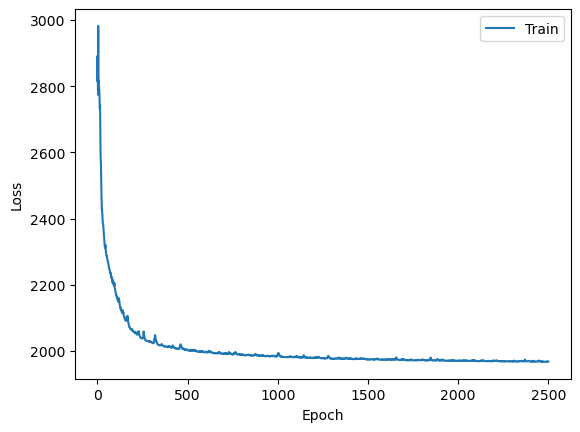

In [12]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Use CVAE model to predict train images

In [13]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[0][0])
reconstruction = vae.decoder.predict(z)

16/16 [==============================] - 1s 9ms/step


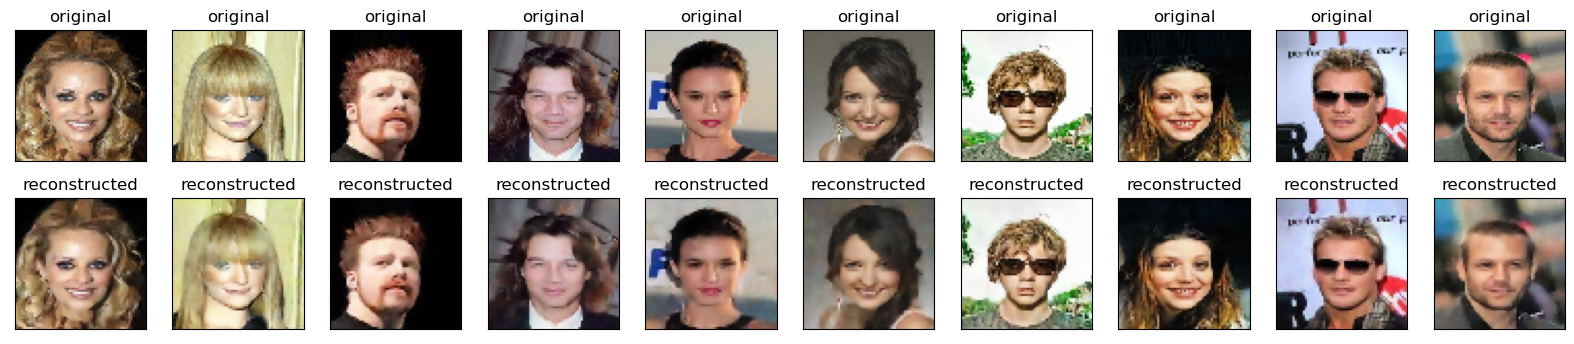

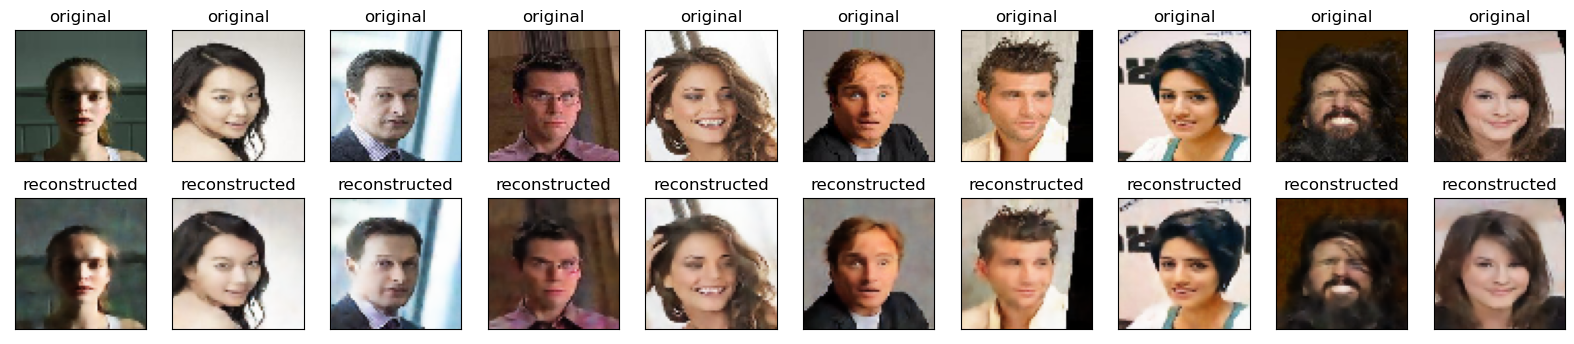

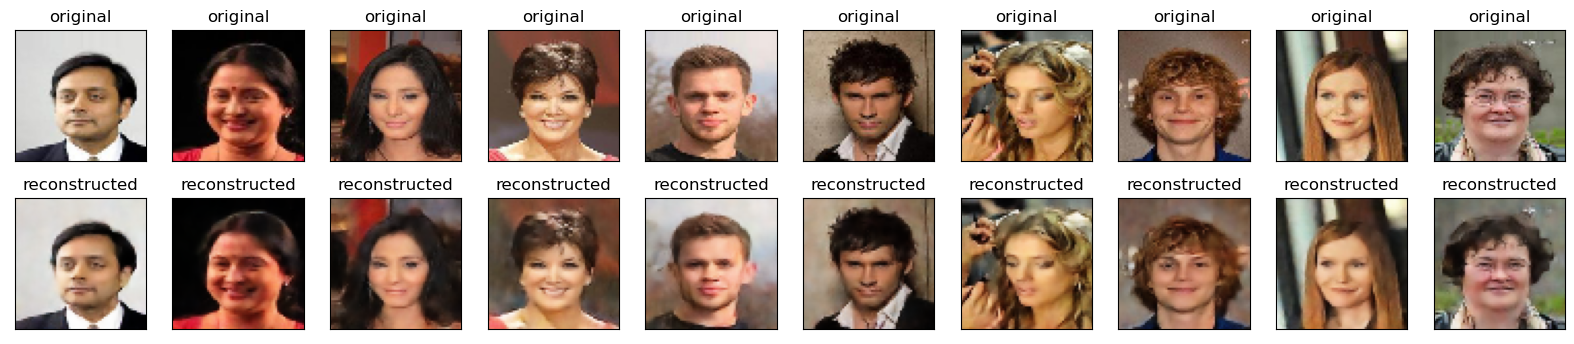

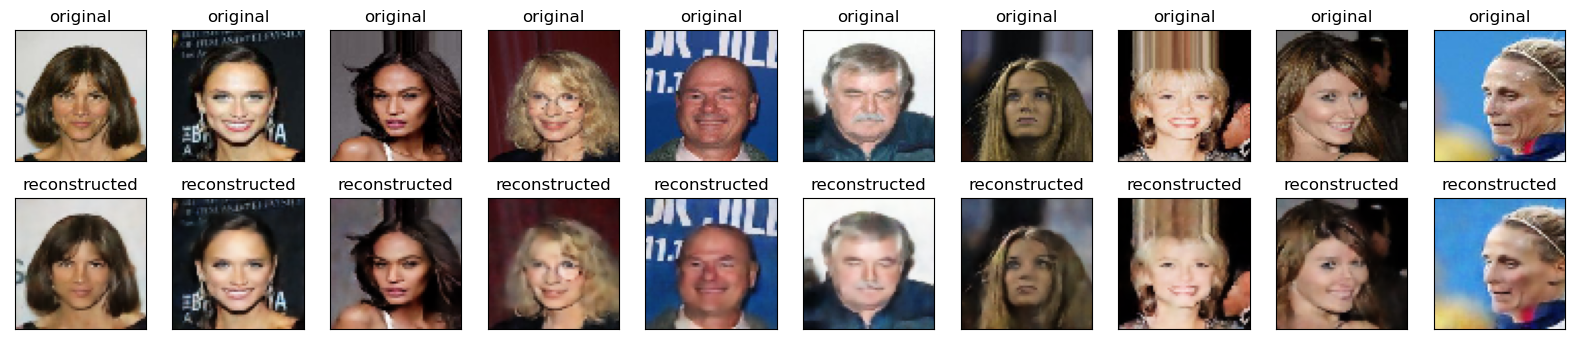

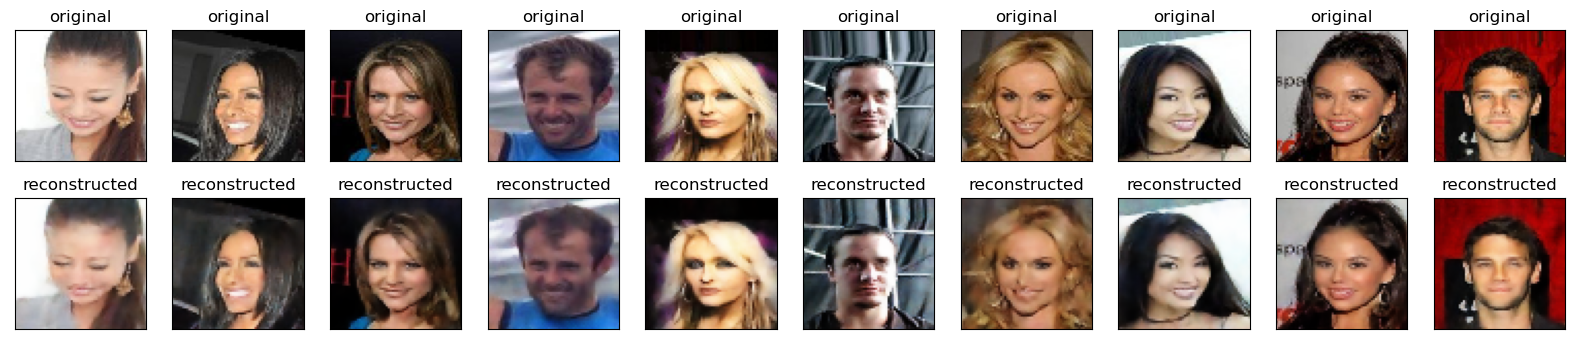

In [14]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[0][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Use CVAE model to predict test images

In [15]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[1][0])
reconstruction = vae.decoder.predict(z)

16/16 [==============================] - 0s 9ms/step


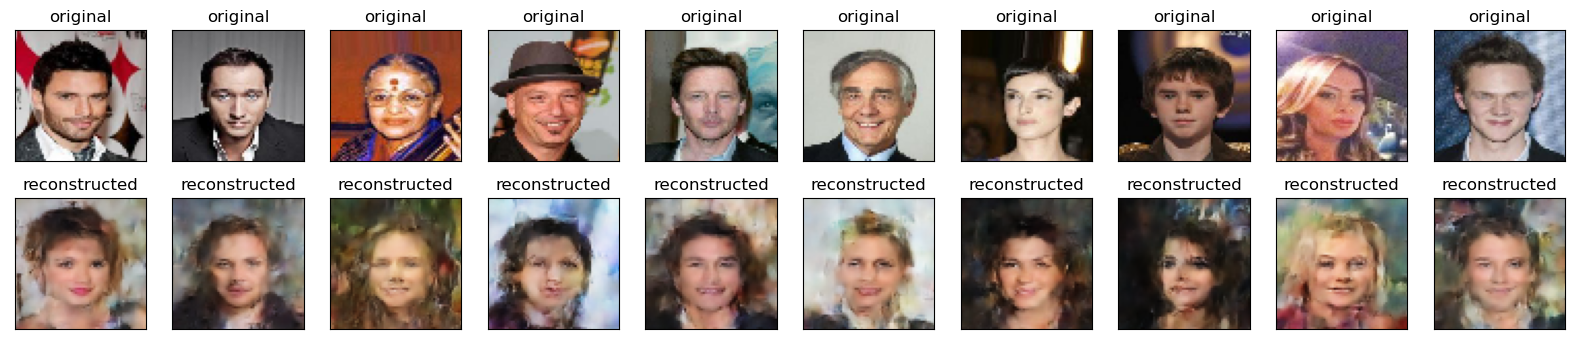

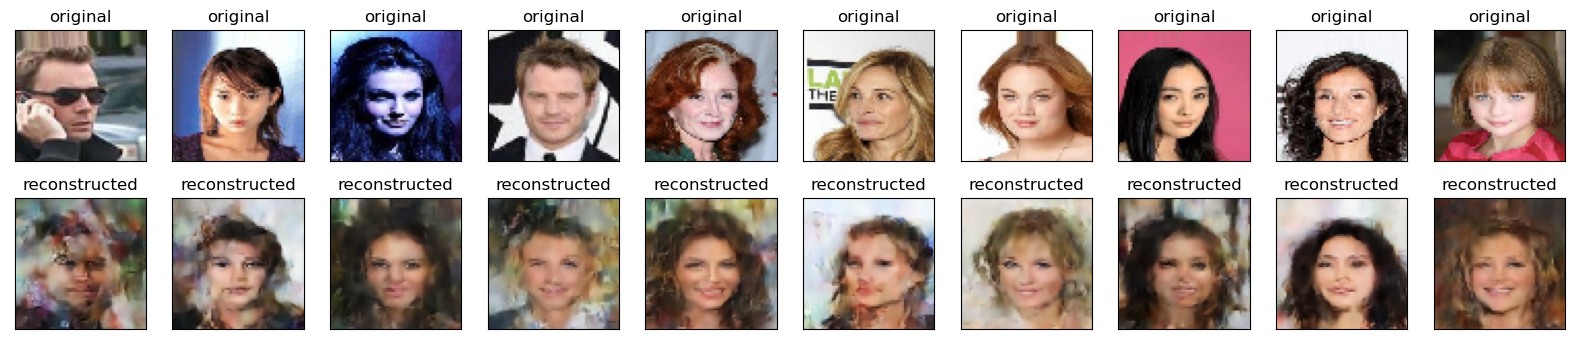

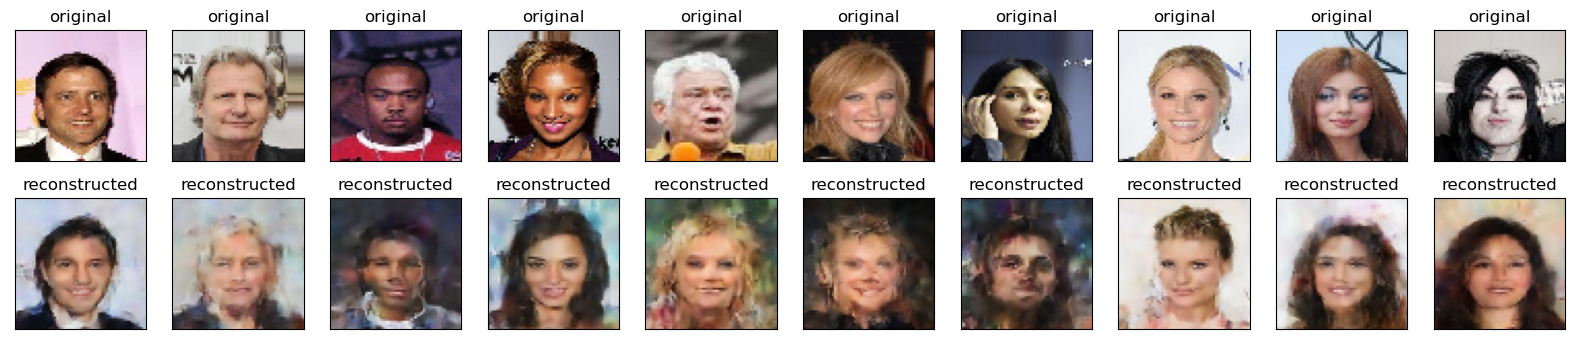

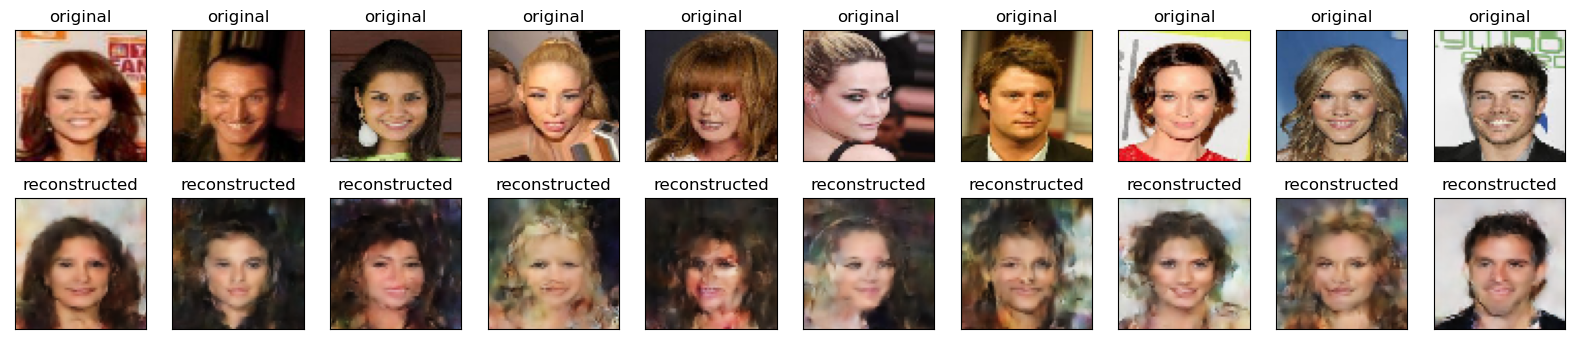

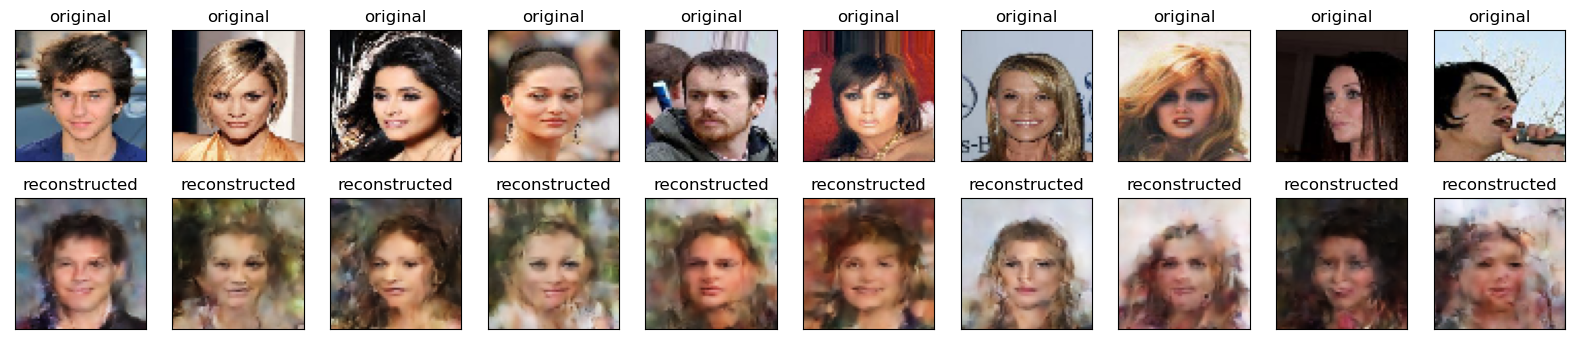

In [16]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[1][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()